In [1]:
from artificial import *


In [2]:
X=crossing_rings_sample(1000)
print(X)

[[-0.24902234 -1.82641973]
 [-1.40612265  0.10425864]
 [-1.79414581 -1.12568649]
 ...
 [ 0.77896129  1.0511061 ]
 [ 0.95616708  0.28891647]
 [-0.7764737   1.07831008]]


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# 1. Suppose X is your NumPy array, shape = (1000, 2)
#    You must convert to a torch.Tensor before passing to TensorDataset
X_tensor = torch.from_numpy(X).float()      # shape (1000, 2)

# 2. Create a TensorDataset containing exactly one tensor (no labels)
dataset = TensorDataset(X_tensor)

# 3. Split dataset into train/test
n_total = len(dataset)           # 1000
n_train = int(0.8 * n_total)     # 800
n_test  = n_total - n_train      # 200
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

# 4. DataLoaders: note that now each batch is a Tensor, not a Python list
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)


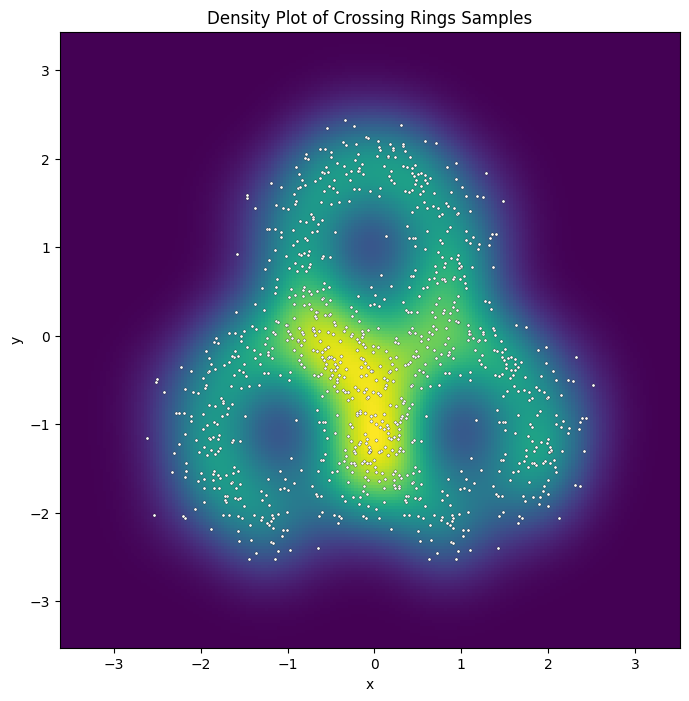

In [4]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Separate coordinates
x = X[:, 0]
y = X[:, 1]

# Perform a Gaussian KDE for density estimation
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the range of the data
xmin, xmax = x.min() - 1, x.max() + 1
ymin, ymax = y.min() - 1, y.max() + 1
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, xx.shape)

# Plot the density map using a blue-to-yellow colormap (viridis)
plt.figure(figsize=(8, 8))
plt.imshow(
    np.rot90(Z),
    cmap='viridis',
    extent=[xmin, xmax, ymin, ymax],
    aspect='auto'
)
plt.scatter(x, y, c='white', s=5, edgecolor='k', linewidth=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Density Plot of Crossing Rings Samples')
plt.show()

In [10]:
import functools
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import CategoricalLayer, GaussianLayer
from cirkit.symbolic.parameters import mixing_weight_factory
from cirkit.templates.utils import (
    Parameterization,
    parameterization_to_factory
)

NUM_INPUT_UNITS = 5
NUM_SUM_UNITS = 5

def define_circuit_from_rg(rg: RegionGraph, sum_prod_layer: str = 'cp') -> Circuit:
    # Here is where Overparameterization comes in
    input_factory = lambda scope, num_units: GaussianLayer(
        scope=scope,
        num_output_units=num_units # Overparameterization
    )

    # We need to specify how to parameterize the sum layers
    # Here we choose to initialize them by sampling from a normal distribution and use softmax as activation function.
    sum_weight_param = Parameterization(activation='softmax', initialization='normal')
    sum_weight_factory = parameterization_to_factory(sum_weight_param)

    # Optionally, we can parameterize sum layers receiving input from more than one other layer differently
    # If the below is not specified, then sum_weight_factory will be used.
    # Instead, we choose to parameterize them such that they compute a weighted combinations of the input vectors.
    # Sum layers of this kind are also referred to as mixing layers. In this particular case, sum layers receiving
    # input from more than one layer are parameterized such that they compute a convex combination of the input vectors.
    nary_sum_weight_factory = functools.partial(mixing_weight_factory, param_factory=sum_weight_factory)

    circuit = rg.build_circuit(
        input_factory=input_factory,
        sum_weight_factory=sum_weight_factory,
        nary_sum_weight_factory=nary_sum_weight_factory,
        num_input_units=NUM_INPUT_UNITS,
        num_sum_units=NUM_SUM_UNITS,
        sum_product=sum_prod_layer
    )
    return circuit

In [11]:
from cirkit.templates.region_graph import RandomBinaryTree

rnd = RandomBinaryTree(2, depth=None, num_repetitions=1)




In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_density_comparison(
    X: np.ndarray,
    trained_circuits: list,
    grid_res: int = 1000,
    batch_size: int = 4096,
    device: torch.device = None
):
    """
    For a set of 2D points X (shape = (N, 2)) and a list of trained density models (circuits),
    compute the “true” Gaussian KDE over X on a grid, then for each circuit evaluate its learned
    density on that same grid and plot a side-by-side comparison.

    Args:
        X (np.ndarray): Array of shape (N, 2) containing the original samples (e.g. from crossing_rings_sample).
        trained_circuits (list): A list of PyTorch modules, each of which, when called on a Tensor of shape (B, 2),
                                 returns a Tensor of log-densities of shape (B,).
        grid_res (int, optional): Resolution of the square grid along each axis (default=1000). 
                                  The grid will be grid_res × grid_res points.
        batch_size (int, optional): How many grid points to process at once to avoid OOM (default=4096).
        device (torch.device, optional): If None, automatically picks CUDA if available, otherwise CPU.

    Returns:
        None. Displays one figure per circuit, with two subplots (true KDE vs. learned density).
    """
    # ────────────────────────────────────────────────────────────────────────────
    # 0. Compute “true” KDE once
    # ────────────────────────────────────────────────────────────────────────────
    # X is assumed to be shape (N, 2)
    x = X[:, 0]
    y = X[:, 1]
    xy = np.vstack([x, y])                      # shape = (2, N)
    kde = gaussian_kde(xy)                      # “true” density estimator

    # Build a square grid (grid_res × grid_res) over the data range
    xmin, xmax = x.min() - 1, x.max() + 1
    ymin, ymax = y.min() - 1, y.max() + 1

    # Create meshgrid of shape (grid_res, grid_res)
    xx, yy = np.mgrid[
        xmin : xmax : grid_res*1j,
        ymin : ymax : grid_res*1j
    ]  # both xx and yy have shape (grid_res, grid_res)

    positions = np.vstack([xx.ravel(), yy.ravel()])  # shape = (2, grid_res²)

    # Evaluate “true” KDE on that grid and reshape for plotting
    Z_true = np.reshape(kde(positions).T, xx.shape)  # (grid_res, grid_res)

    # ────────────────────────────────────────────────────────────────────────────
    # 1. Determine device
    # ────────────────────────────────────────────────────────────────────────────
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ────────────────────────────────────────────────────────────────────────────
    # 2. Loop over each circuit, evaluate model density on the grid, and plot
    # ────────────────────────────────────────────────────────────────────────────
    for idx, circuit in enumerate(trained_circuits):
        # Move model to device and set to eval mode
        circuit = circuit.to(device)
        circuit.eval()

        # Convert grid points to a torch.Tensor of shape (grid_res², 2) on `device`
        grid_tensor = torch.from_numpy(positions.T).float().to(device)

        n_points = grid_tensor.shape[0]           # grid_res²
        log_probs_chunks = []

        # Evaluate in batches to avoid OOM
        with torch.no_grad():
            for i in range(0, n_points, batch_size):
                chunk = grid_tensor[i : i + batch_size]     # shape = (≤batch_size, 2)
                logp_chunk = circuit(chunk)                 # shape = (≤batch_size,)
                log_probs_chunks.append(logp_chunk.cpu())

        # Concatenate all log-probs and exponentiate to get p_model
        log_probs_all = torch.cat(log_probs_chunks, dim=0)      # shape = (grid_res²,)
        p_model = torch.exp(log_probs_all).numpy()              # shape = (grid_res²,)

        # Reshape into (grid_res, grid_res)
        Z_model = p_model.reshape(xx.shape)                     # (grid_res, grid_res)

        # ────────────────────────────────────────────────────────────────────────────
        # 3. Plot “true” KDE vs. model’s learned density side by side
        # ────────────────────────────────────────────────────────────────────────────
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))

        # ─── Left: True KDE ───────────────────────────────────────────────────────
        im0 = ax0.imshow(
            np.rot90(Z_true),
            cmap='viridis',
            extent=[xmin, xmax, ymin, ymax],
            aspect='auto'
        )
        ax0.scatter(x, y, c='white', s=5, edgecolor='k', linewidth=0.2)
        ax0.set_xlabel('x')
        ax0.set_ylabel('y')
        ax0.set_title(f'Circuit #{idx}: True KDE')
        fig.colorbar(im0, ax=ax0, label='Density')

        # ─── Right: Model’s Learned Density ───────────────────────────────────────
        im1 = ax1.imshow(
            np.rot90(Z_model),
            cmap='viridis',
            extent=[xmin, xmax, ymin, ymax],
            aspect='auto'
        )
        ax1.scatter(x, y, c='white', s=5, edgecolor='k', linewidth=0.2)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title(f'Circuit #{idx}: Model Density')
        fig.colorbar(im1, ax=ax1, label='Density')

        plt.suptitle(f'Density Comparison for Circuit #{idx}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()



Training circuit with region graph "random-binary-tree + cp"
Step 1000: Average NLL: 2.920
Step 2000: Average NLL: 2.806
Step 3000: Average NLL: 2.802
Step 4000: Average NLL: 2.801
Step 5000: Average NLL: 2.801
Step 6000: Average NLL: 2.800
Step 7000: Average NLL: 2.800
Step 8000: Average NLL: 2.800
Step 9000: Average NLL: 2.800
Step 10000: Average NLL: 2.800
Step 11000: Average NLL: 2.800
Step 12000: Average NLL: 2.800
Step 13000: Average NLL: 2.800
Step 14000: Average NLL: 2.800
Step 15000: Average NLL: 2.800
Step 16000: Average NLL: 2.797
Step 17000: Average NLL: 2.777
Step 18000: Average NLL: 2.773
Step 19000: Average NLL: 2.773
Step 20000: Average NLL: 2.772
Average test LL: 2.836
Bits per dimension: 2.046

Training circuit with region graph "random-binary-tree + Tucker"
Step 1000: Average NLL: 2.998
Step 2000: Average NLL: 2.866
Step 3000: Average NLL: 2.862
Step 4000: Average NLL: 2.860
Step 5000: Average NLL: 2.853
Step 6000: Average NLL: 2.839
Step 7000: Average NLL: 2.836
St

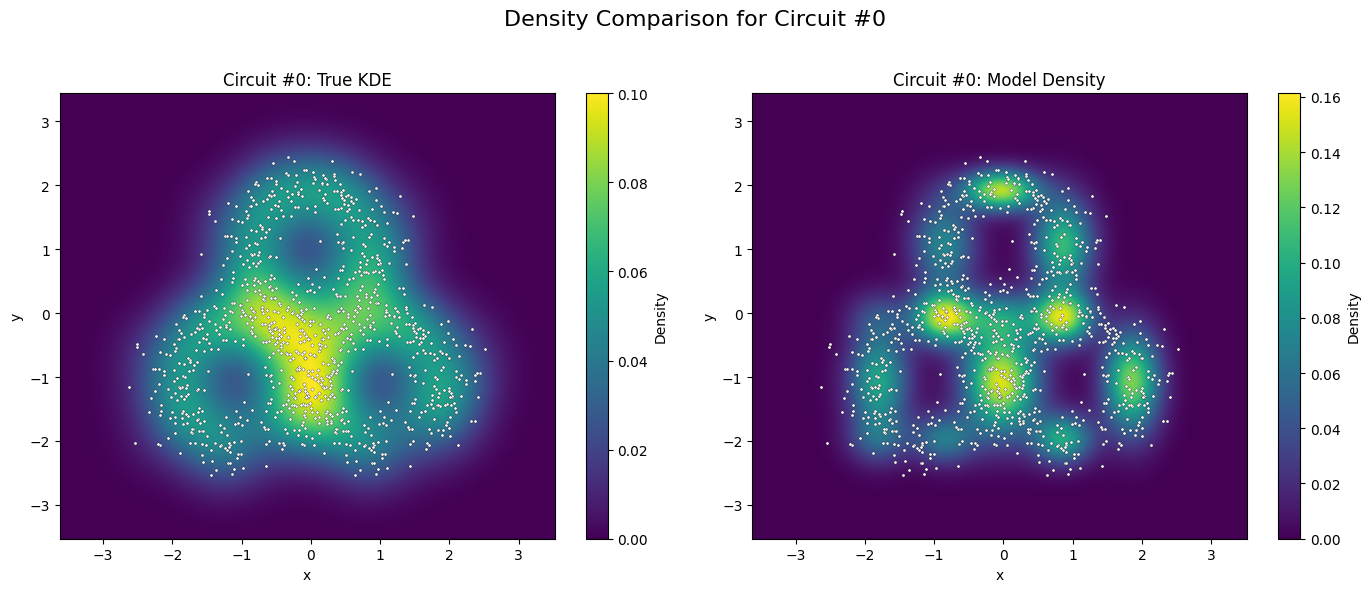

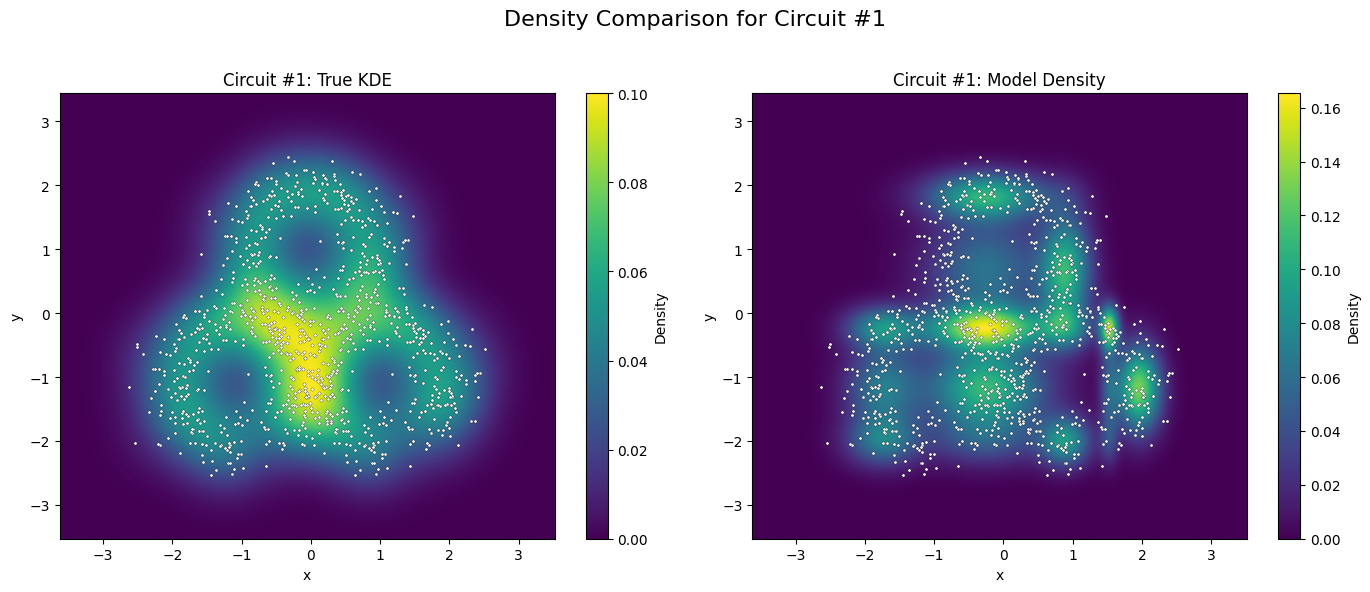

In [13]:
import random
import torch
import numpy as np



from cirkit.pipeline import compile


def train_and_eval_circuit(cc):

    # Set some seeds
    # random.seed(42)
    # np.random.seed(42)
    # torch.manual_seed(42)
    # torch.cuda.manual_seed(42)
    
    # Set the torch device to use
    device = torch.device('cuda')

    # Compile the circuit
    circuit = compile(cc)
    
    # Move the circuit to chosen device
    circuit = circuit.to(device)
    
    num_epochs = 5000
    step_idx = 0
    running_loss = 0.0
    running_samples = 0
    stats = dict()

    stats['# trainable parameters'] = sum(p.numel() for p in circuit.parameters() if p.requires_grad)
    stats['train loss'] = []
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.01)
    
    for epoch_idx in range(num_epochs):
        for i, (batch,) in enumerate(train_dataloader):
            #print(i)
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)
    
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)
    
            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            running_samples += len(batch)
            step_idx += 1
            if step_idx % 1000 == 0:
                average_nll = running_loss / running_samples
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                running_samples = 0
                
                stats['train loss'].append(average_nll.cpu().item())

    with torch.no_grad():
        test_lls = 0.0
    
        for batch in test_dataloader:
            
            #print(batch)
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch[0].shape[0]
            batch = batch[0].view(BS, -1).to(device)
    
            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)
    
            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()
    
        # Compute average test log-likelihood and bits per dimension
        average_nll = - test_lls / len(test_dataset)
        bpd = average_nll / (2 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")
        
        stats['test loss'] = average_nll
        stats['test bits per dimension'] = bpd

    # Free GPU memory
    circuit = circuit.to('cpu')
    torch.cuda.empty_cache()
    stats['train loss (min)'] = min(stats['train loss'])
    return stats,circuit

circuits = dict()
circuits['random-binary-tree + cp'] = define_circuit_from_rg(rnd)   # cp is the default second argument
circuits['random-binary-tree + Tucker'] = define_circuit_from_rg(rnd, 'tucker')
results = dict()
trained_circuits = []
for k, cc in circuits.items():
    print('\nTraining circuit with region graph "%s"' % k)
    
    results[k],circuit = train_and_eval_circuit(cc)
    trained_circuits.append(circuit)
    results[k]['sum product layer'] = k.split('+')[1]
plot_density_comparison(X, trained_circuits, grid_res=1000, batch_size=4096)
